## Exploración de los datos para su entendimiento.


In [1]:
#pip install medmnist
#pip install tensorflow


Forma del set de entrenamiento: (4708, 28, 28)
Número de clases: 2
Etiquetas: {'0': 'normal', '1': 'pneumonia'}


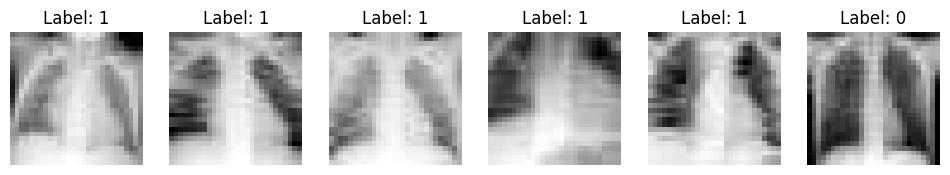

Número total de imágenes (train+test+val): 5856
Cantidad por clase:
  Clase 1 (pneumonia): 4273
  Clase 0 (normal): 1583


In [1]:

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import medmnist
from medmnist import INFO, Evaluator
from medmnist import PneumoniaMNIST

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import collections

# Seleccionamos el dataset
data_flag = 'pneumoniamnist'
download = True

# Obtenemos información del dataset
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# Cargar datos
train_dataset = DataClass(split='train', download=download)
test_dataset = DataClass(split='test', download=download)
val_dataset = DataClass(split='val', download=download)

print(f"Forma del set de entrenamiento: {train_dataset.imgs.shape}")
print(f"Número de clases: {len(info['label'])}")
print(f"Etiquetas: {info['label']}")

# Mostrar algunas imágenes
fig, axes = plt.subplots(1, 6, figsize=(12, 2))
for i in range(6):
    axes[i].imshow(train_dataset.imgs[i].squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {train_dataset.labels[i][0]}")
    axes[i].axis('off')
plt.show()

# Contar cantidad de cada clase en los datasets
labels_train = train_dataset.labels.flatten()
labels_test = test_dataset.labels.flatten()
labels_val = val_dataset.labels.flatten()

all_labels = np.concatenate([labels_train, labels_test, labels_val])
counts = collections.Counter(all_labels)

print(f"Número total de imágenes (train+test+val): {len(all_labels)}")
print("Cantidad por clase:")
for label, count in counts.items():
    print(f"  Clase {label} ({info['label'][str(label)]}): {count}")


## Preparación de los datos para poder utilizarlos como entrada en modelos de deep learning.


In [2]:
# Convertir imágenes a float32 y normalizar
x_train = train_dataset.imgs.astype('float32') / 255.0
x_test = test_dataset.imgs.astype('float32') / 255.0
x_val = val_dataset.imgs.astype('float32') / 255.0

# Expandir dimensión de canal (por si es necesario para conv2D)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_val = np.expand_dims(x_val, -1)

# Convertir etiquetas a categóricas (one-hot encoding)
y_train = to_categorical(train_dataset.labels, num_classes=2)
y_test = to_categorical(test_dataset.labels, num_classes=2)
y_val = to_categorical(val_dataset.labels, num_classes=2)

print("x_train:", x_train.shape)
print("y_train:", y_train.shape)


x_train: (4708, 28, 28, 1)
y_train: (4708, 2)


## Análisis sobre la selección del modelo de deep learning apropiado y la estrategia de estimación y calibración.

Un ejemplo de modelo usando transfer learnning: Usamos red EfficientNetB0 como base para modelo y adicionamos una capa de dropout y la capa de salida para la prediccion.

In [3]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
import tensorflow as tf

# Función para convertir imágenes grayscale a RGB
def to_rgb(images):
    return np.repeat(images, 3, axis=-1)

# Redimensionar imágenes a 32x32 para EfficientNetB0
def resize_images(images, size=(32,32)):
    images_resized = tf.image.resize(images, size).numpy()
    return images_resized

# Convertir a RGB
x_train_rgb = to_rgb(x_train)
x_val_rgb = to_rgb(x_val)
x_test_rgb = to_rgb(x_test)

# Redimensionar a 32x32
x_train_rgb = resize_images(x_train_rgb, (32,32))
x_val_rgb = resize_images(x_val_rgb, (32,32))
x_test_rgb = resize_images(x_test_rgb, (32,32))

print("x_train_rgb shape:", x_train_rgb.shape)

# Definir modelo EfficientNetB0 preentrenado
base_model = EfficientNetB0(include_top=False, input_shape=(32,32,3), weights='imagenet', pooling='avg')
base_model.trainable = False  # Congelar base para transfer learning inicial

inputs = Input(shape=(32,32,3))
x = base_model(inputs, training=False)
x = Dropout(0.3)(x)
outputs = Dense(2, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

x_train_rgb shape: (4708, 32, 32, 3)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Entrenar modelo

In [ ]:
history = model.fit(x_train_rgb, y_train, validation_data=(x_val_rgb, y_val), epochs=5, batch_size=32)


Epoch 1/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7196 - loss: 0.5954 - val_accuracy: 0.7424 - val_loss: 0.5730
Epoch 2/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7474 - loss: 0.5778 - val_accuracy: 0.7424 - val_loss: 0.5854
Epoch 3/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7382 - loss: 0.5859 - val_accuracy: 0.7424 - val_loss: 0.5698
Epoch 4/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7301 - loss: 0.5951 - val_accuracy: 0.7424 - val_loss: 0.5716
Epoch 5/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7406 - loss: 0.5830 - val_accuracy: 0.7424 - val_loss: 0.5767


**Predicciones**

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Accuracy en test: 0.6250


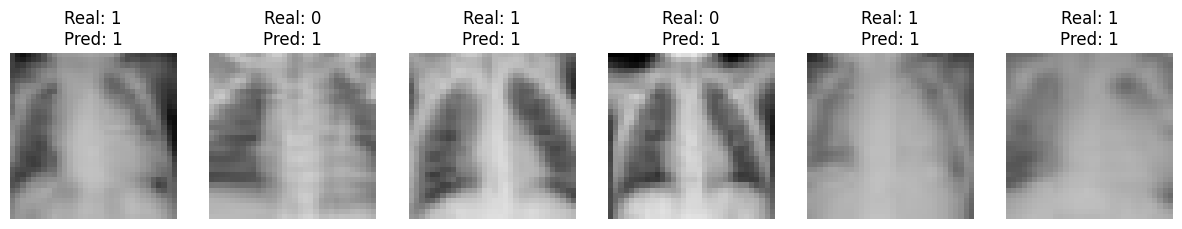

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Obtener predicciones (probabilidades)
y_pred_probs = model.predict(x_test_rgb)

# Convertir probabilidades a etiquetas (clase con máxima probabilidad)
y_pred = np.argmax(y_pred_probs, axis=1)

# Etiquetas reales (no one-hot)
y_true = np.argmax(y_test, axis=1)

# Calcular accuracy simple en test
accuracy = np.mean(y_pred == y_true)
print(f"Accuracy en test: {accuracy:.4f}")

# Mostrar algunas imágenes con predicción y etiqueta real
num_to_show = 6
fig, axes = plt.subplots(1, num_to_show, figsize=(15,3))

for i in range(num_to_show):
    axes[i].imshow(x_test_rgb[i])
    axes[i].axis('off')
    axes[i].set_title(f"Real: {y_true[i]}\nPred: {y_pred[i]}")

plt.show()
